In [1]:
#Import needed libraries:
import cv2
import matplotlib
import numpy as np
import PIL as PIL
import torch
import torchvision
import os
import pandas as pd
from torch.utils.data import Dataset
from skimage import io
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets

In [6]:
#Download the dataset from kaggle:
#kaggle API token need to be uploaded to colab first in /content/
!pip install -q kaggle
!rm -r ~/.kaggle
! mkdir ~/.kaggle
! sudo cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:57<00:00, 36.8MB/s]
100% 3.24G/3.24G [00:57<00:00, 60.6MB/s]


In [7]:
#unzip the dataset file:
!unzip /content/a-large-scale-fish-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00447.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00448.png  
  inflating: Fish_Dataset/Fish_Dataset/

In [8]:
#remove al the GT directories:
!rm -r "/content/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT"
!rm -r "/content/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream GT"
!rm -r "/content/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel GT"
!rm -r "/content/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet GT"
!rm -r "/content/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream GT"
!rm -r "/content/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass GT"
!rm -r "/content/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp GT"
!rm -r "/content/Fish_Dataset/Fish_Dataset/Striped Red Mullet/Striped Red Mullet GT"
!rm -r "/content/Fish_Dataset/Fish_Dataset/Trout/Trout GT"

In [9]:
#Importing Data / Preparing Dataloaders:
data_dir = "/content/Fish_Dataset/Fish_Dataset" 
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
    ])
#Loader Parameters:
num_workers = 0
batch_size = 20

#Main Dataset:
main_dataset = datasets.ImageFolder(data_dir, transform=transform)

#Split Dataset to : train , validate and test
dataset_size = len(main_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
train_idx, validation_idx , test_idx = indices[:int(0.7*dataset_size)], indices[int(0.7*dataset_size):int(0.8*dataset_size)] , indices[int(0.8*dataset_size):]

# define samplers for obtaining training , validation and test batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(validation_idx)
test_sampler = SubsetRandomSampler(test_idx)

#loaders:
train_loader = torch.utils.data.DataLoader(main_dataset, batch_size=batch_size,num_workers=num_workers , sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(main_dataset, batch_size=batch_size,num_workers=num_workers , sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(main_dataset, batch_size=batch_size,num_workers=num_workers , sampler=test_sampler)
loaders_transfer = {'train': train_loader, 'valid': validation_loader, 'test': test_loader}

classes = main_dataset.classes
print("Classes : " + str(classes))
print("Dataset size : " + str(dataset_size))

Classes : ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
Dataset size : 9000


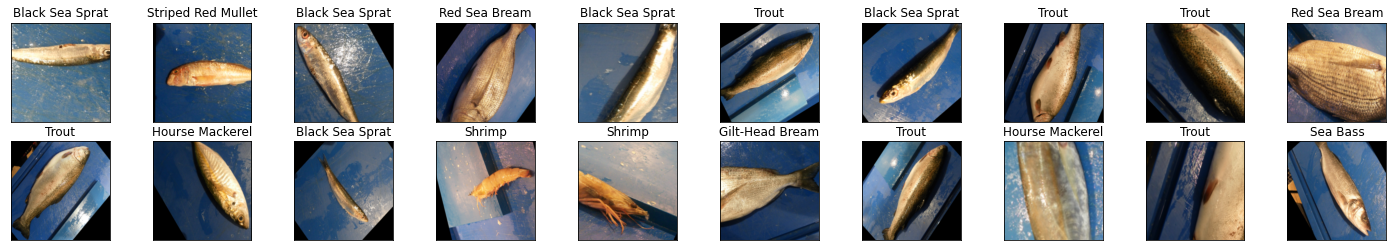

In [10]:
#Visualize our dataset (load one batch):
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = np.transpose(img, (1, 2, 0)) # convert from Tensor image
    plt.imshow(img)  

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
#print(labels)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[int(labels[idx])])

In [11]:
import torch.optim as optim
#assign a manual seed to be used for weight initialization for re-producable results:
torch.manual_seed(0)

#select loss function
criterion_transfer = torch.nn.CrossEntropyLoss()

#we define a custom optimizer to only update unfrozen weights , since we are using a pre-trained network(vgg16)
def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    return optimizer  

In [12]:
import torch.nn as nn
from torchvision import models

# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

n_inputs = vgg16.classifier[6].in_features
# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))
vgg16.classifier[6] = last_layer

model_transfer = vgg16

use_cuda = True

if use_cuda:
    model_transfer = model_transfer.cuda()
print("Done!")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Done!


In [13]:
#define the training/validation function:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            #optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            #loss.backward()
            #optimizer.step()
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
          valid_loss_min = valid_loss
          torch.save(model.state_dict(), save_path)

        
        
    return model

In [14]:
#define the test funciton:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [15]:
#train our model then save the best verison:
num_epochs = 5
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 0.612261 	Validation Loss: 0.279202
Epoch: 2 	Training Loss: 0.324621 	Validation Loss: 0.233030
Epoch: 3 	Training Loss: 0.258124 	Validation Loss: 0.186528
Epoch: 4 	Training Loss: 0.252157 	Validation Loss: 0.180537
Epoch: 5 	Training Loss: 0.222354 	Validation Loss: 0.188022


In [16]:
#test our model:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.174891


Test Accuracy: 93% (1689/1800)


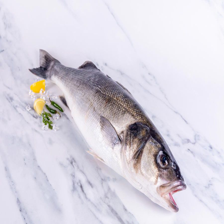

Predicted Classes (top 3): ['Sea Bass', 'Gilt-Head Bream', 'Trout']


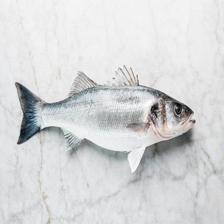

Predicted Classes (top 3): ['Sea Bass', 'Gilt-Head Bream', 'Trout']


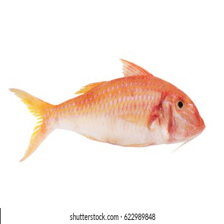

Predicted Classes (top 3): ['Red Mullet', 'Striped Red Mullet', 'Shrimp']


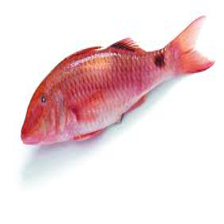

Predicted Classes (top 3): ['Red Mullet', 'Striped Red Mullet', 'Red Sea Bream']


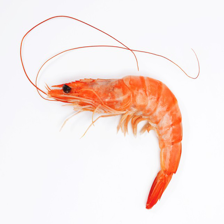

Predicted Classes (top 3): ['Shrimp', 'Red Mullet', 'Sea Bass']


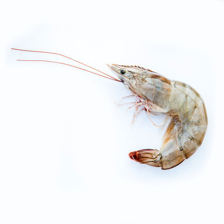

Predicted Classes (top 3): ['Shrimp', 'Hourse Mackerel', 'Red Sea Bream']


In [24]:
#define a prediction function to make our model easy to use for real application:
def predict(img_path):
  img = PIL.Image.open(img_path)
  img = img.resize((224,224))# resize
  #display image:
  display(img)
  #convert img to Tensor:
  trans = transforms.ToTensor()
  img = trans(img)
  #apply to our model:
  model_transfer.eval()
  img = img.unsqueeze(0)
  output = model_transfer(img.cuda())
  values , class_indices = torch.topk(output,3)
  class_indices = class_indices.cpu().detach().numpy()[0].astype(int)
  predicted_classes = list(classes[i] for i in class_indices)
  print("Predicted Classes (top 3): " + str(predicted_classes))

  return predicted_classes

#test on uploaded image 1:
predicted_1 = predict("/content/test_images/Sea_Bass_1.jpg")

#test on uploaded image 2:
predicted_1 = predict("/content/test_images/Sea_Bass_2.jpg")

#test on uploaded image 3:
predicted_1 = predict("/content/test_images/red_mullet_1.jpg")

#test on uploaded image 4:
predicted_1 = predict("/content/test_images/red_mullet_2.jpg")

#test on uploaded image 5:
predicted_1 = predict("/content/test_images/shrimp_1.jpg")

#test on uploaded image 6:
predicted_1 = predict("/content/test_images/shrimp_2.jpg")